In [1]:
import h5py, os, glob
import matplotlib.pyplot as plt
from matplotlib import cm
import numpy as np
from imp import reload

from noise_correlations.data import datasets
from noise_correlations import discriminability, null_models
from noise_correlations.discriminability import lfi_data, lda_data, corrected_lfi_data
from noise_correlations.null_models import random_rotation_data, shuffle_data

In [2]:
# data paths
folder = 'crcns_pvc3_cat_recordings/drifting_bar'

In [3]:
reload(datasets)
ds = datasets.BlancheCRCNSpvc3_cat(folder)

In [4]:
angles, X_1h, X_cos, Y = ds.bin_spikes(bin_ms=500.)

In [4]:
angles, X_1h, X_cos, Y = ds.trial_design_matrices()

In [132]:
angle_list = np.array(sorted(set(angles)))
n_angles = angle_list.size

In [25]:
trials_per_angle = np.zeros_like(angle_list)
for ii, angle in enumerate(angle_list):
    trials_per_angle[ii] = (angles == angle).sum()
assert np.all(trials_per_angle[0] == trials_per_angle[1:])

In [26]:
Yp = np.full((Y.shape[1], angle_list.size, trials_per_angle[0]), -1, dtype=int)
for ii in range(Y.shape[1]):
    for jj, angle in enumerate(angle_list):
        Yp[:, jj] = Y[np.where(angles == angle)[0]].T
assert Yp.min() >= 0
center_angles = Yp.mean(axis=-1).argmax(axis=1)

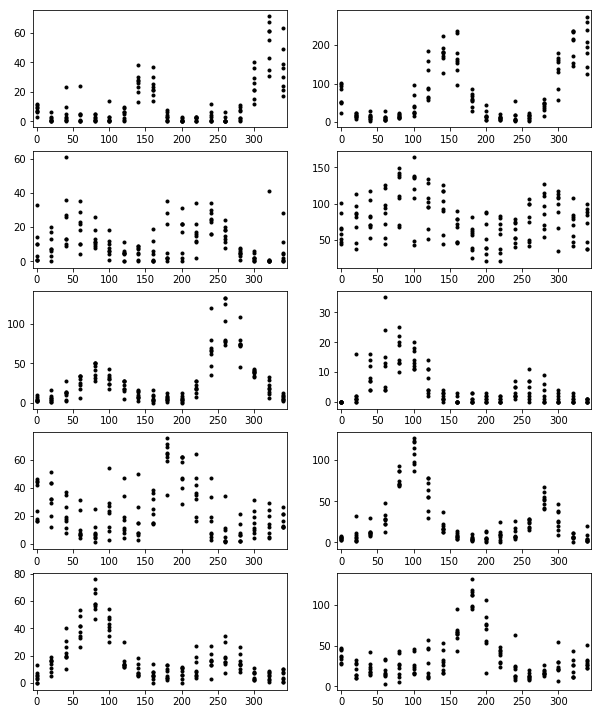

In [5]:
fig, axes = plt.subplots(Y.shape[1]//2, 2, figsize=(10, 12.5))
for ax_idx, ax in enumerate(axes.ravel()):
    for idx, angle in enumerate(sorted(set(angles))):
        counts = Y[:, ax_idx][angles == angle]
        ax.scatter(np.tile(angle, counts.size), counts, marker='.', color='k')
    ax.set_xlim([sorted(set(angles))[0]-5, sorted(set(angles))[-1]+5])

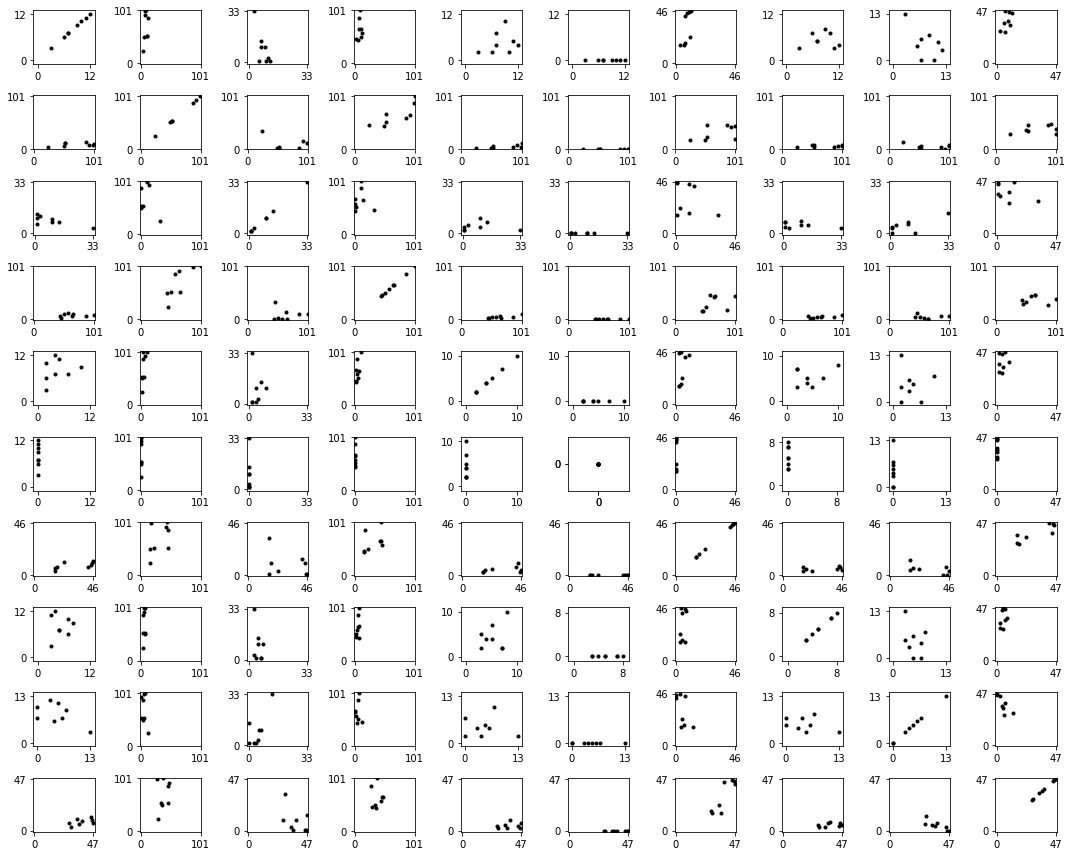

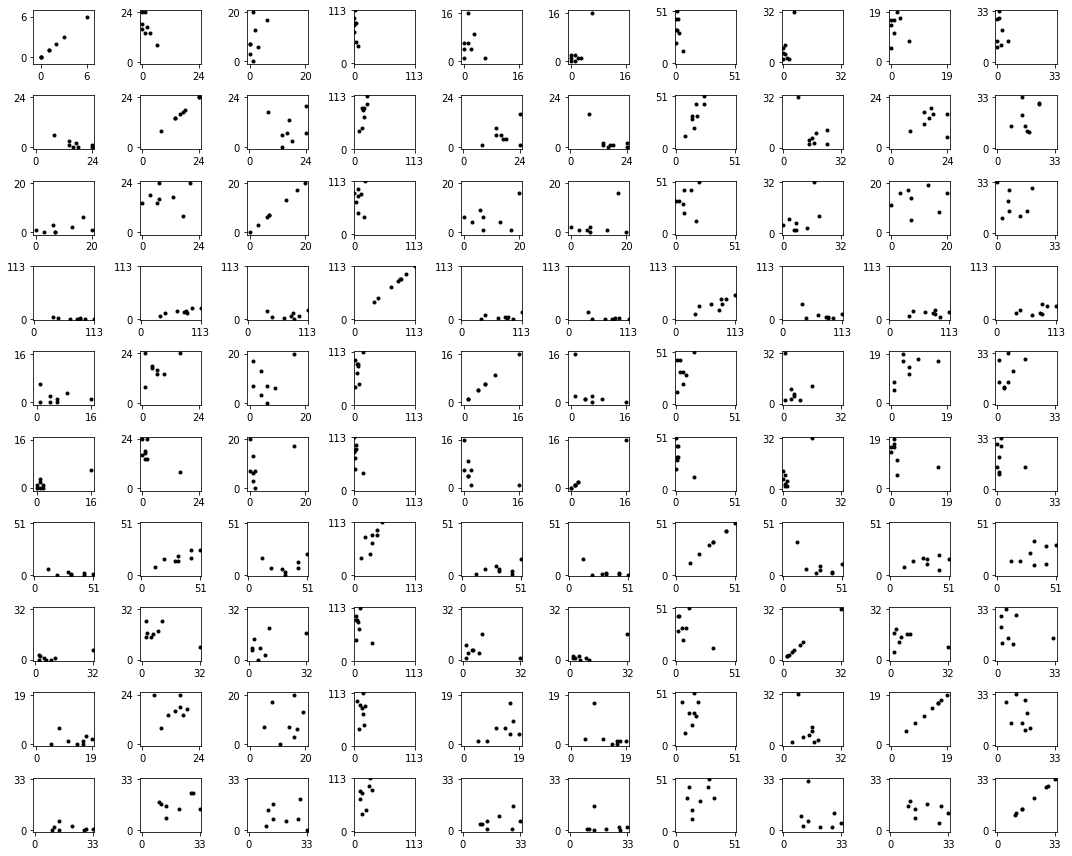

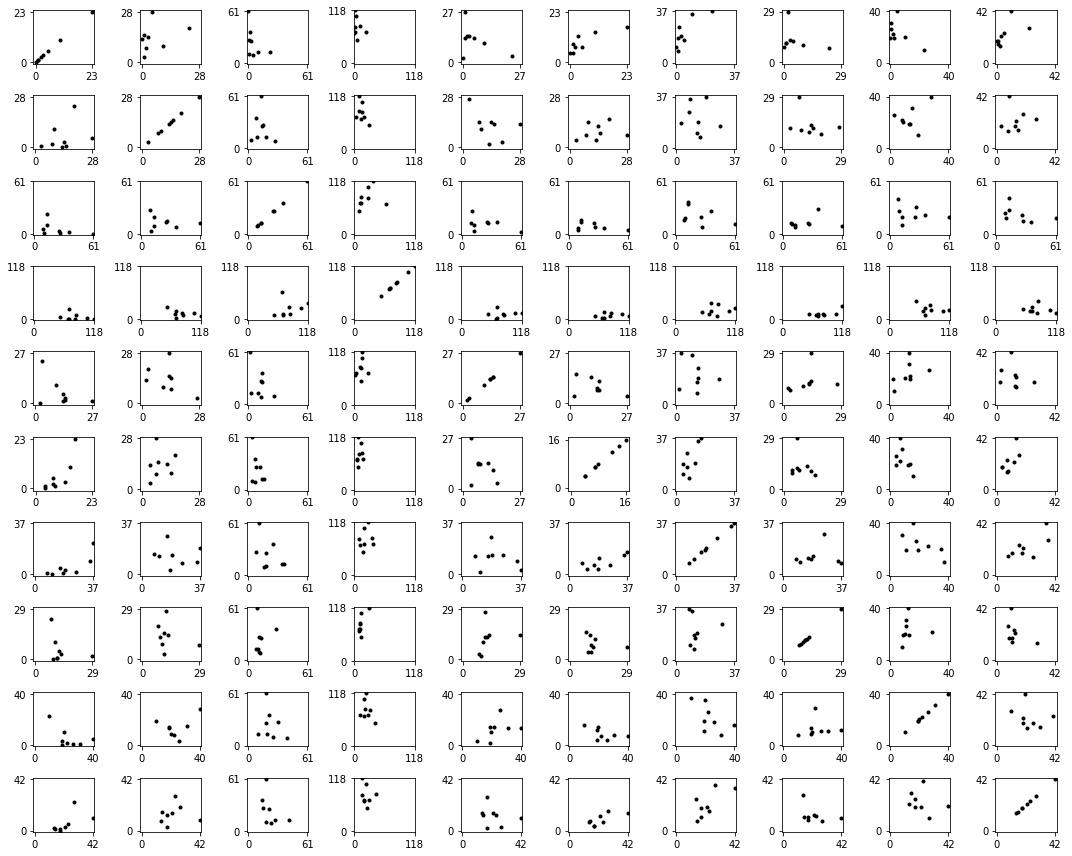

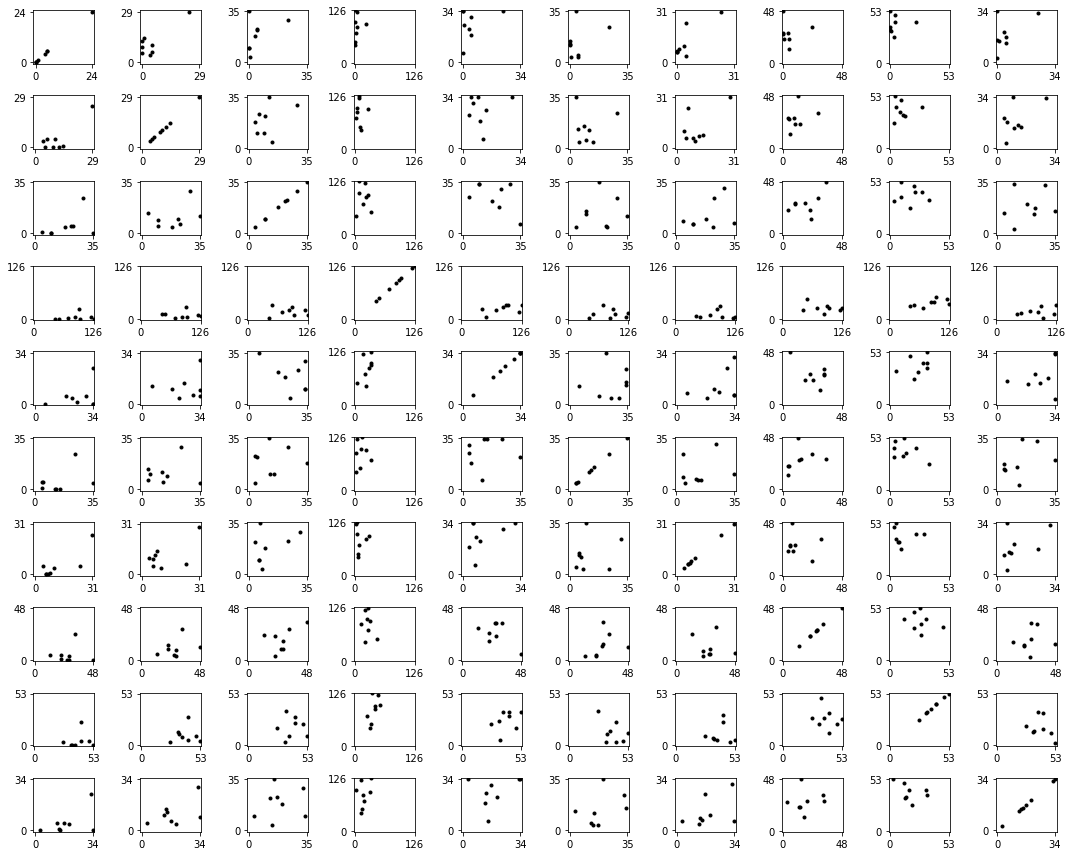

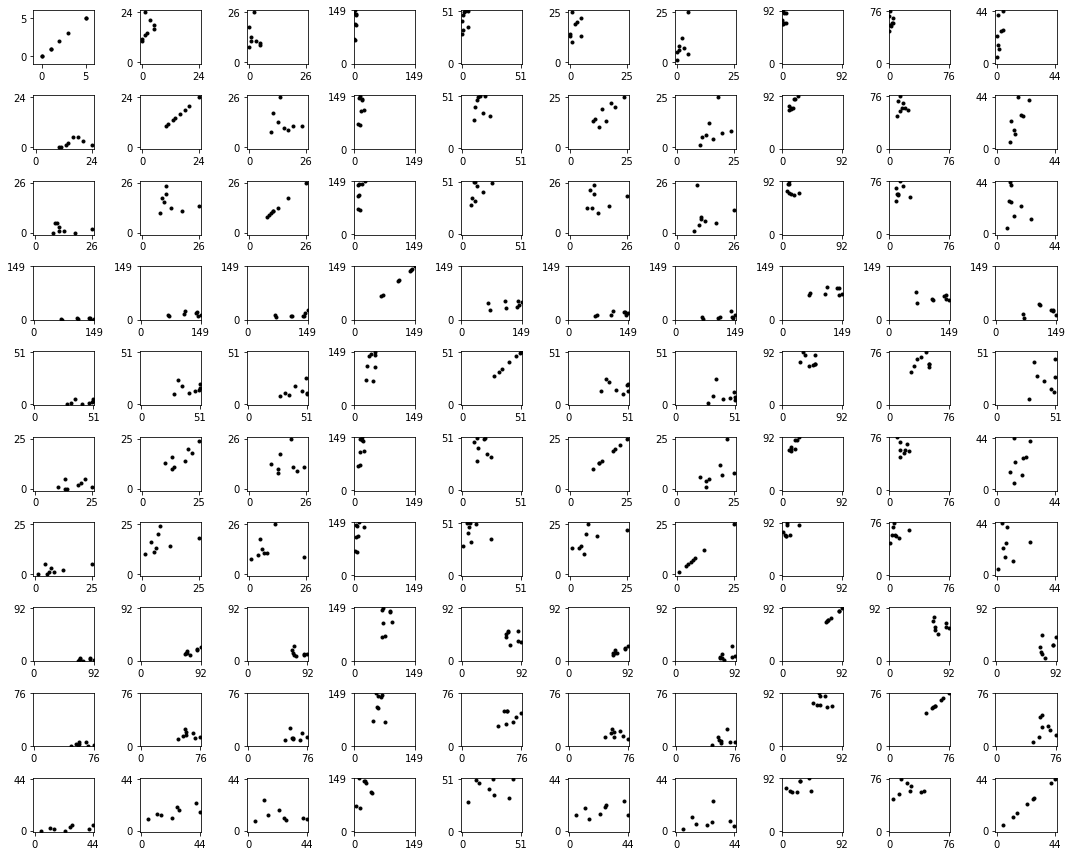

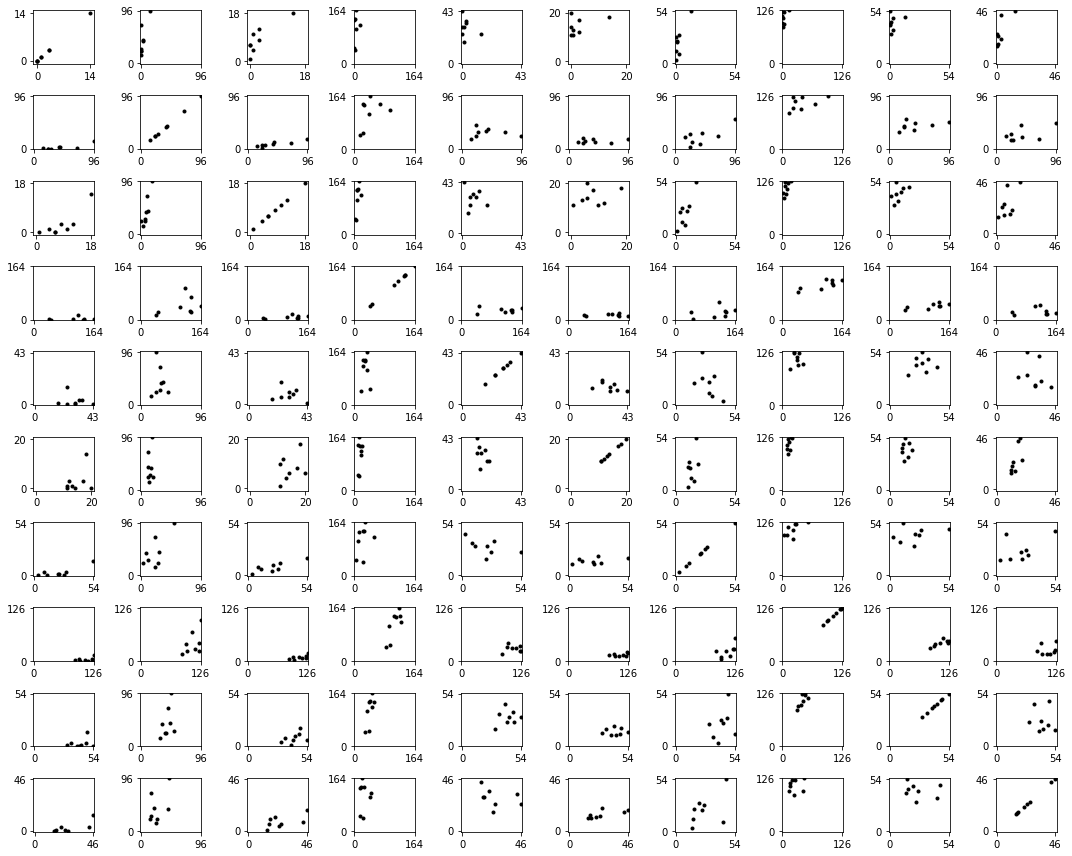

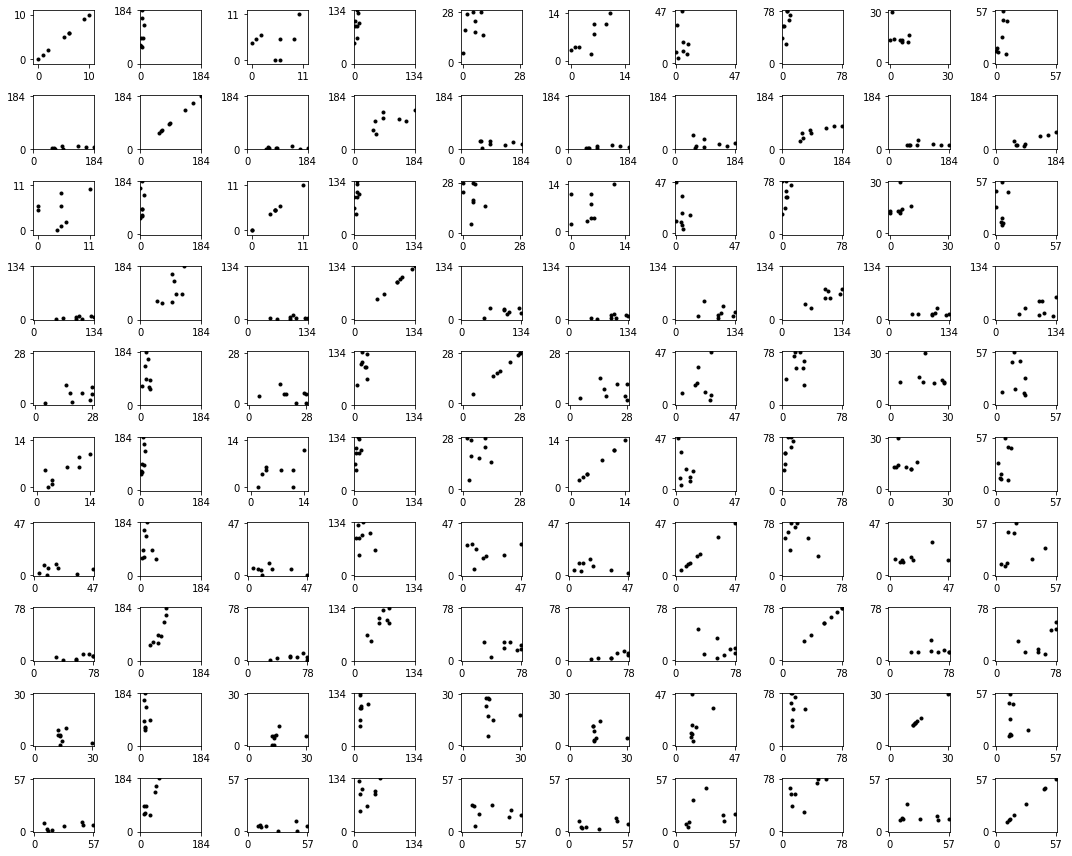

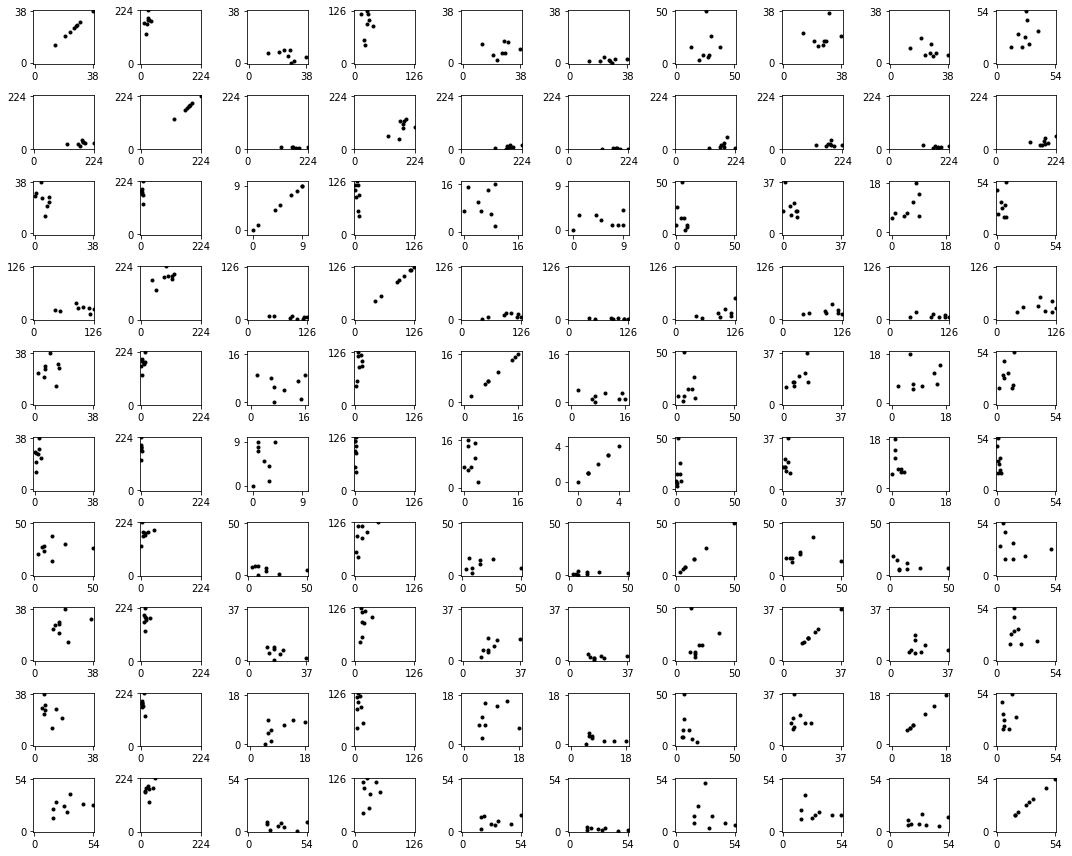

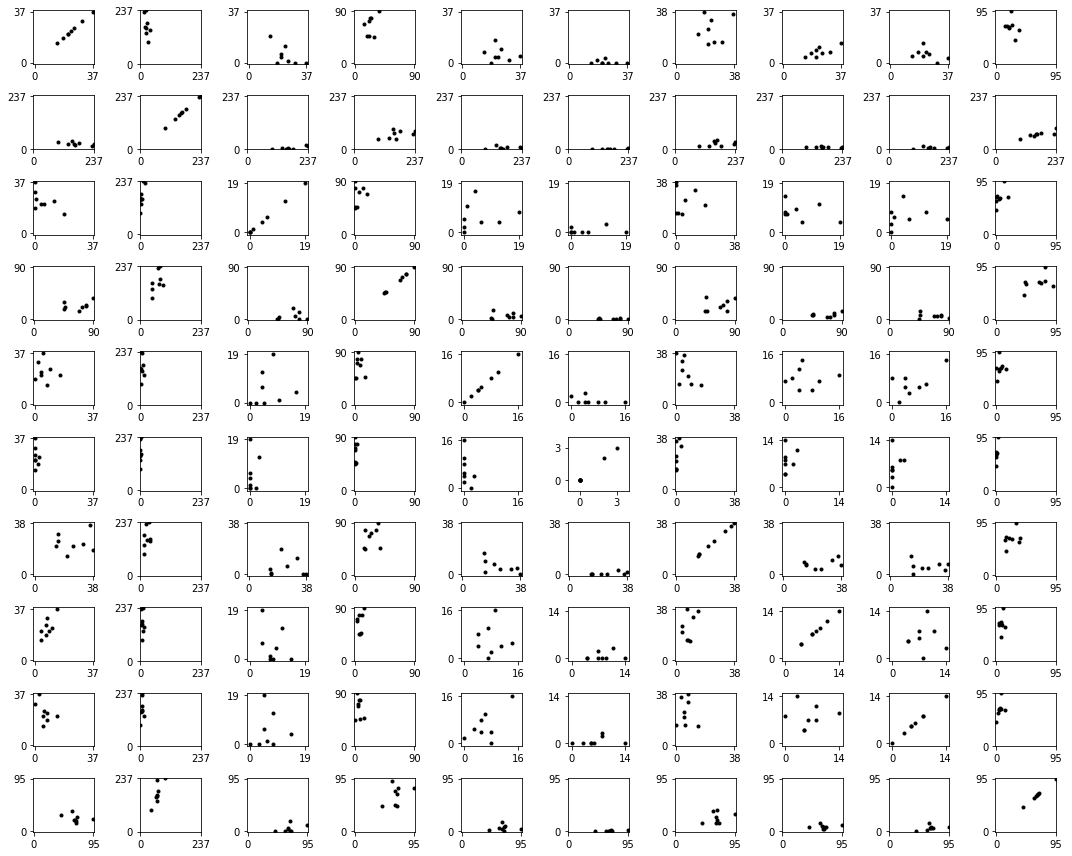

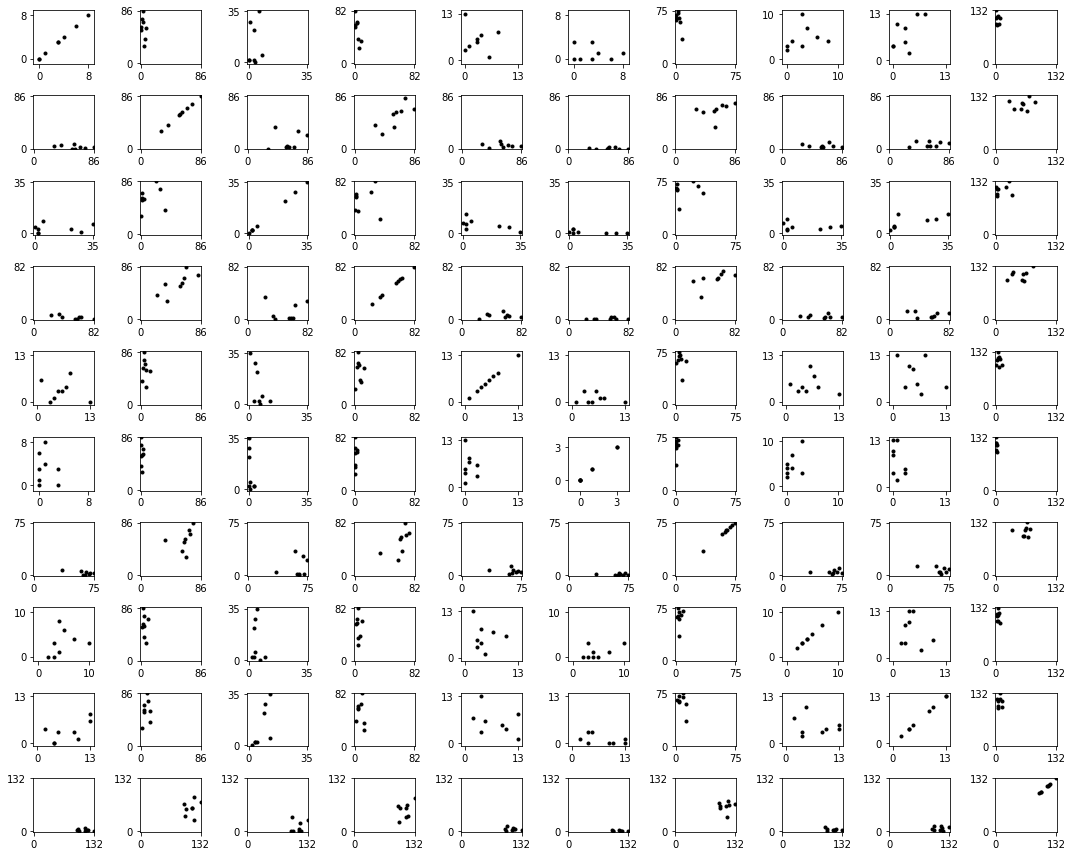

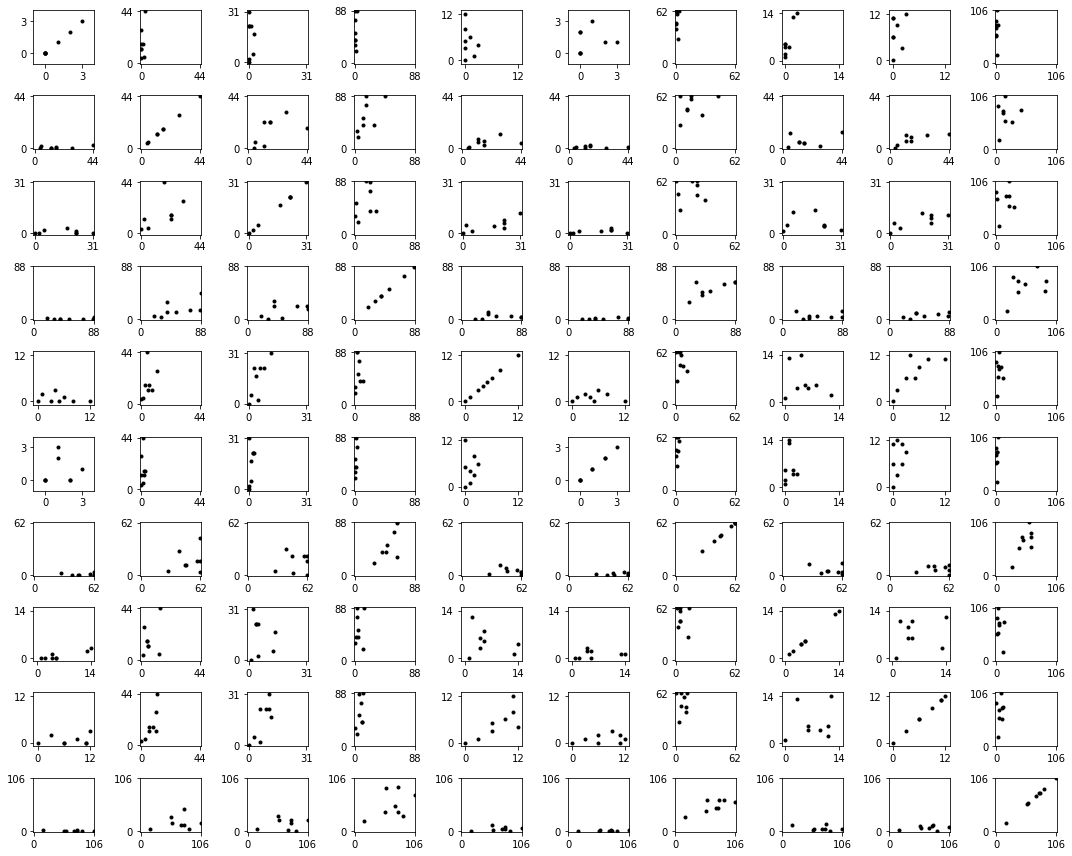

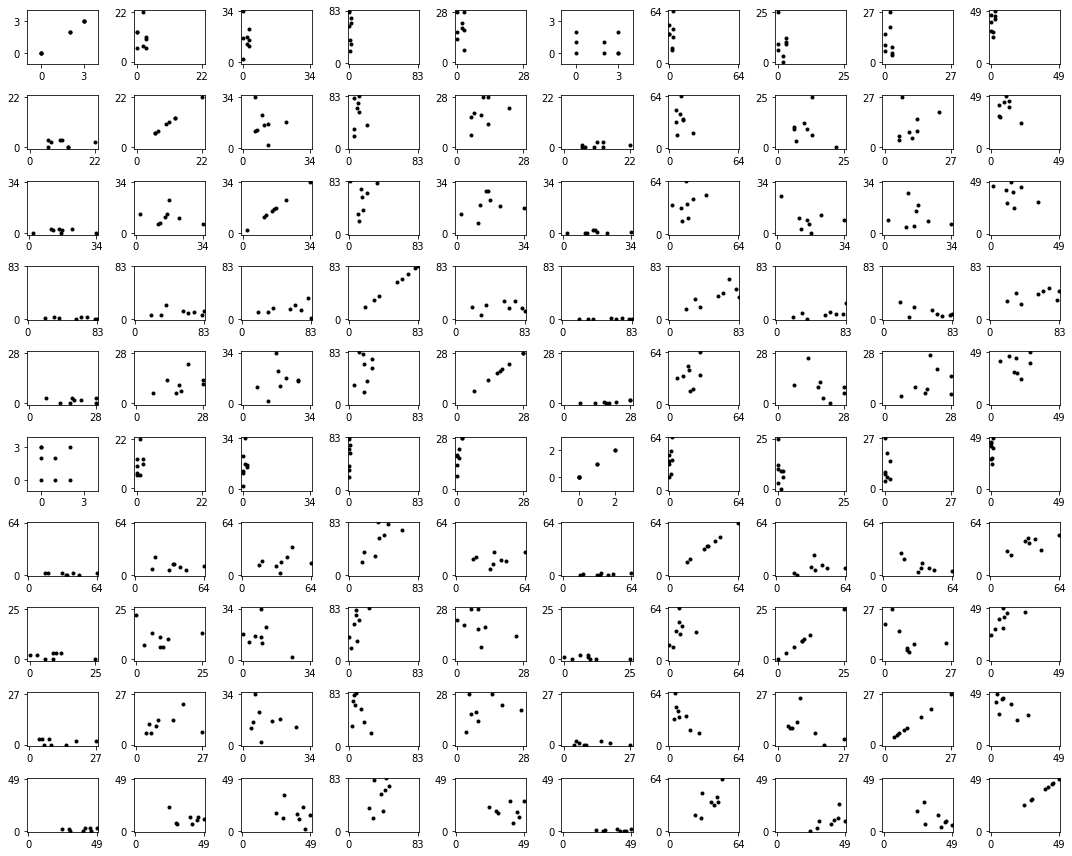

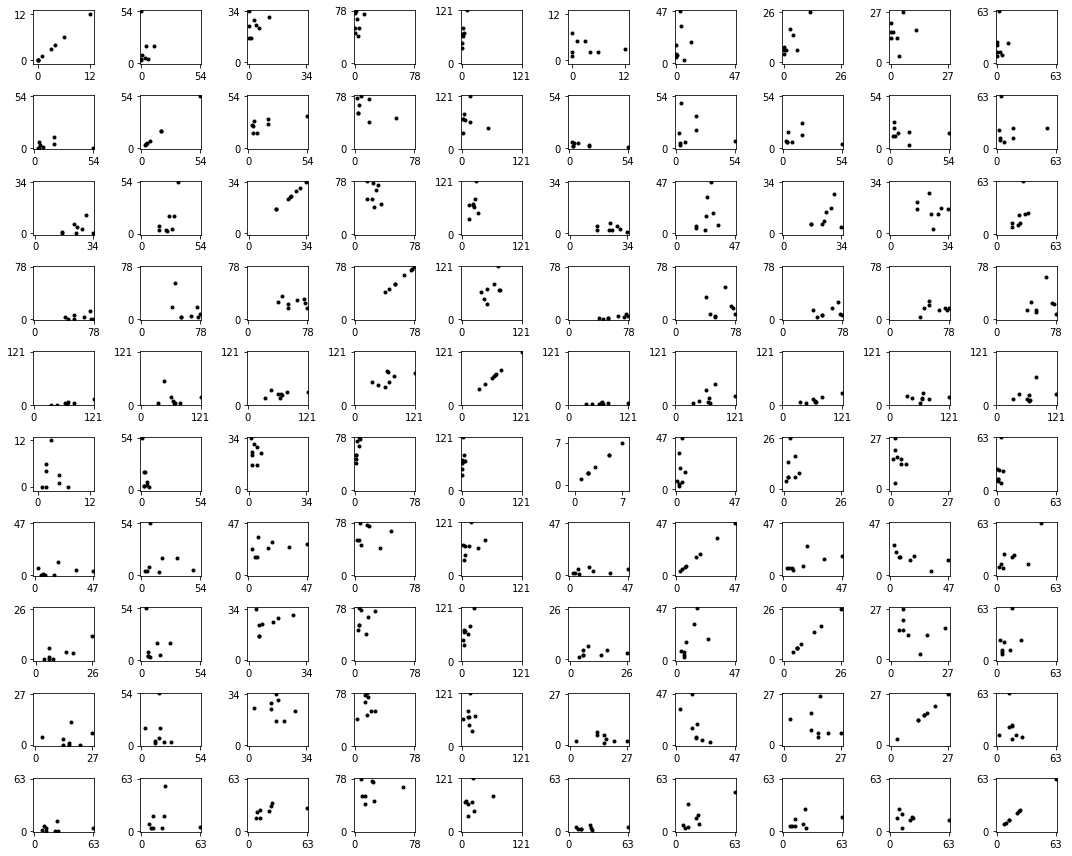

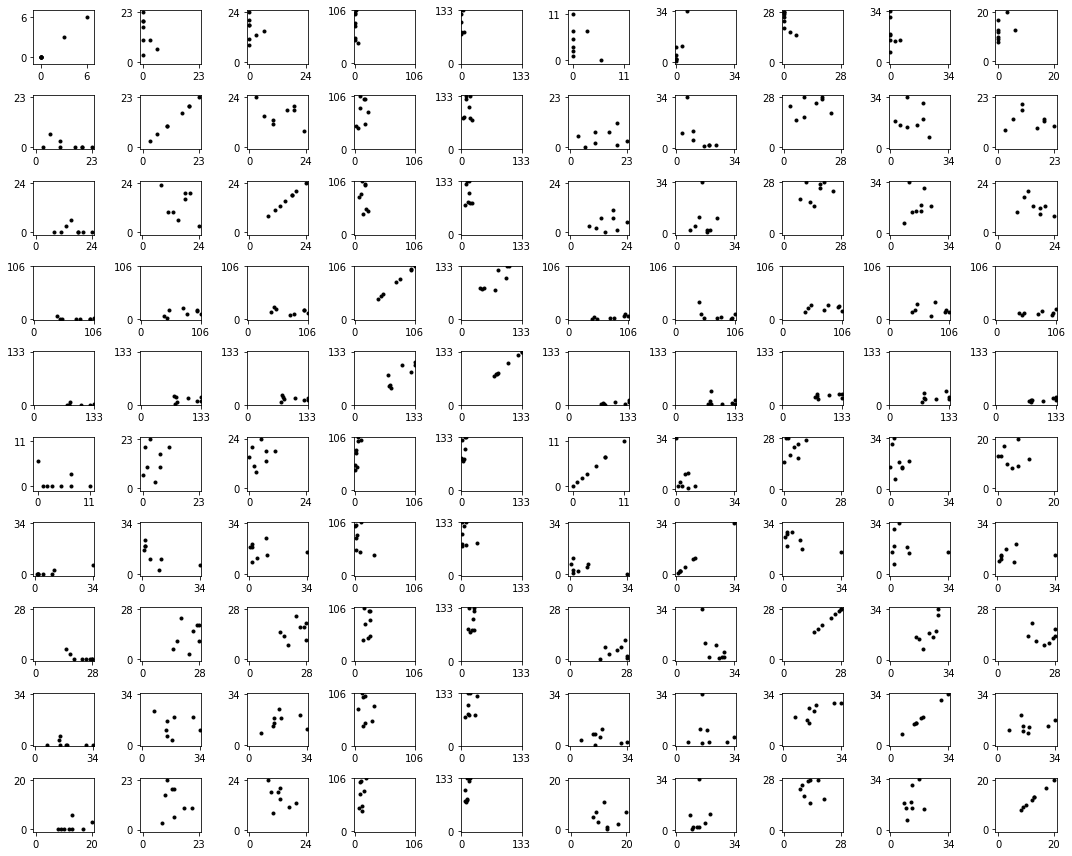

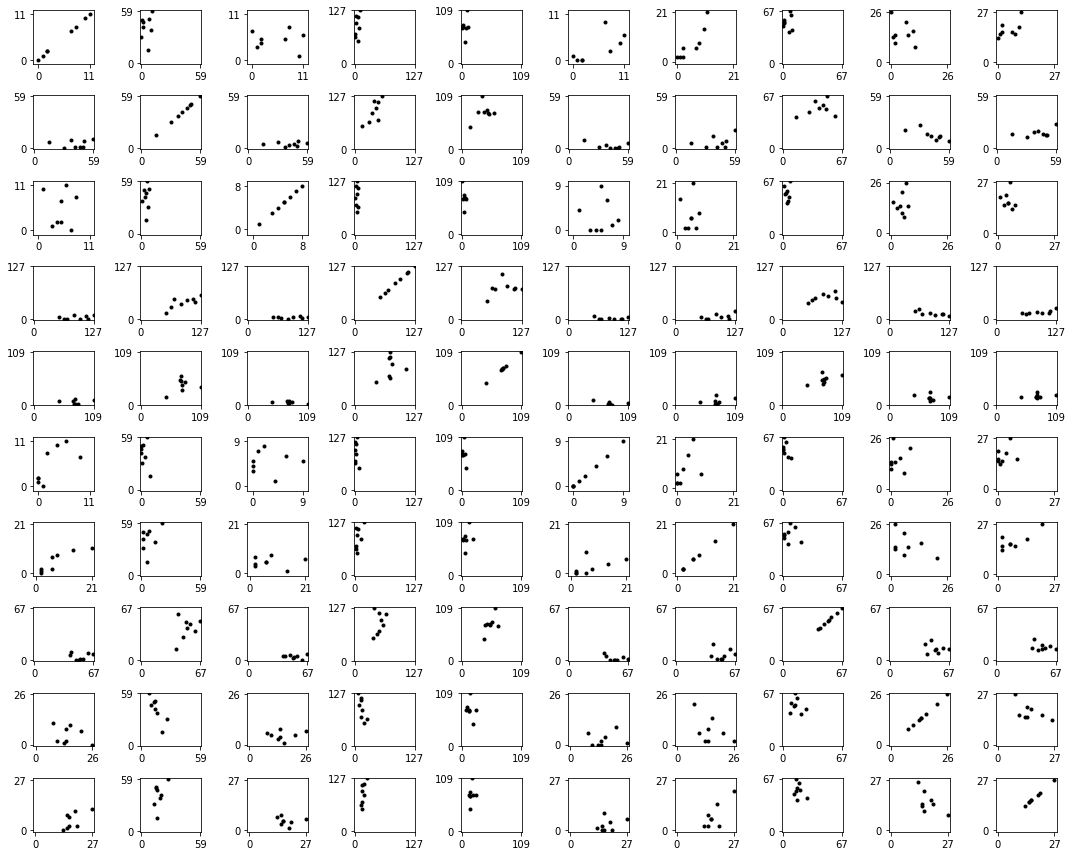

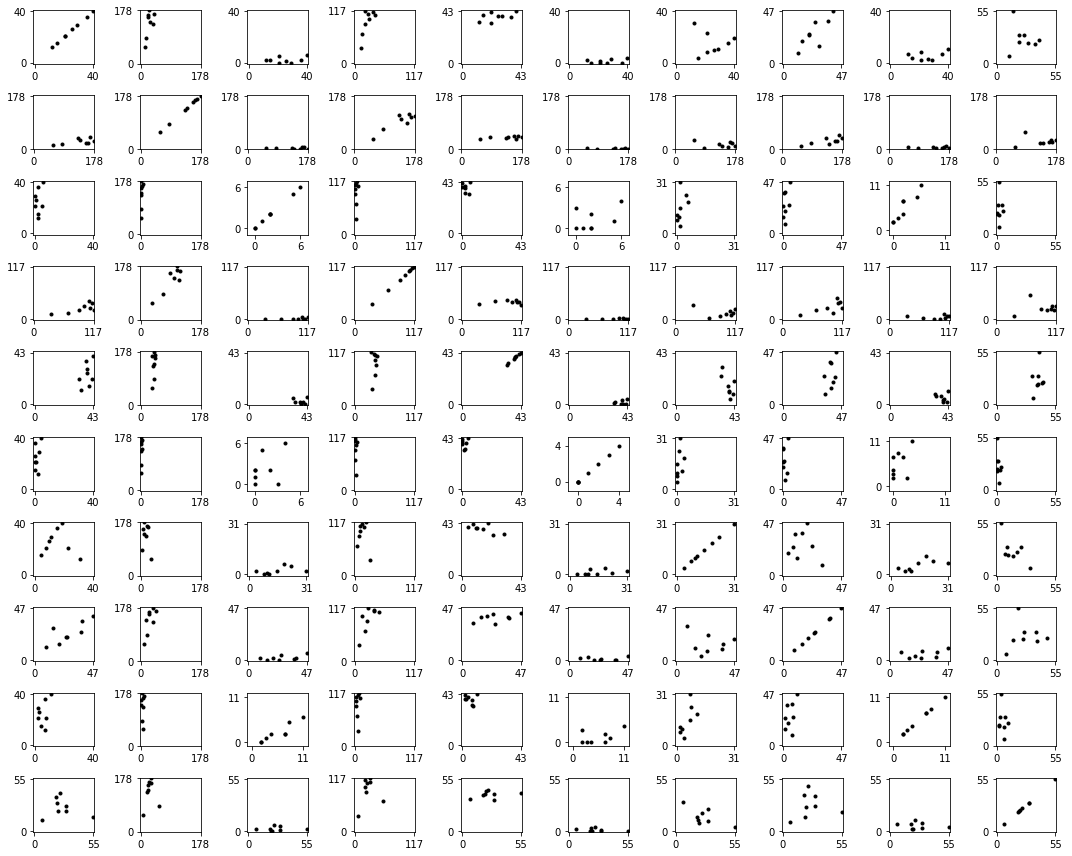

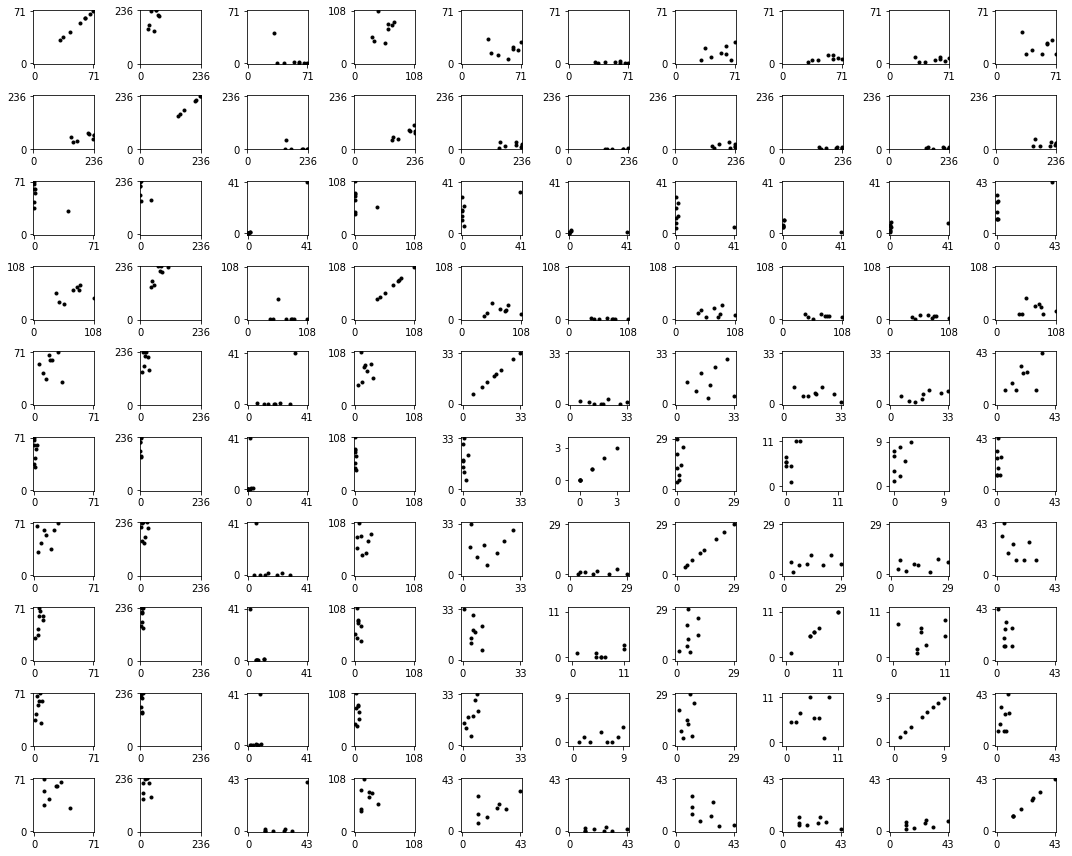

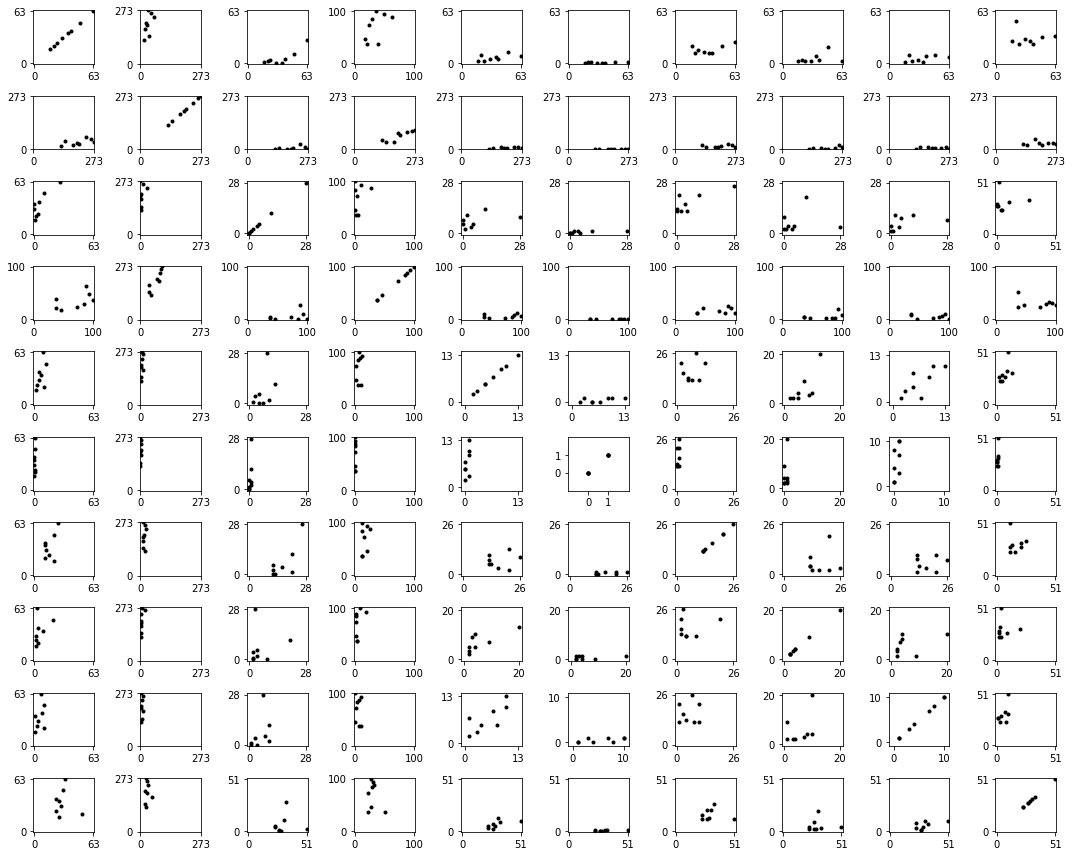

In [41]:
n_neurons = Y.shape[1]
for angle in sorted(set(angles)):
    idxs = np.where(angle == angles)[0]
    Yp = Y[idxs]
    f, axes = plt.subplots(n_neurons, n_neurons, figsize=(15, 12))
    for ii in range(n_neurons):
        for jj in range(n_neurons):
            ax = axes[ii, jj]
            ax.scatter(Yp[:, ii], Yp[:, jj], marker='.', color='k')
            m = max(Yp[:, ii].max(), Yp[:, jj].max())
            ax.set_xlim(-1, m+1)
            ax.set_ylim(-1, m+1)
            ax.set_xticks([0, m])
            ax.set_yticks([0, m])
    f.tight_layout()

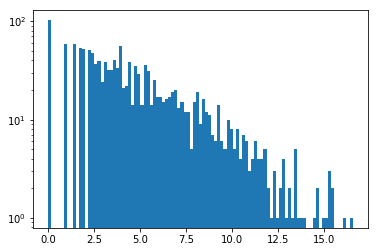

In [21]:
bins = np.linspace(0, np.sqrt(Y.max()+1), 100)
plt.hist(np.sqrt(Y).ravel(), bins=bins)
plt.yscale('log')

In [18]:
x = np.sqrt(Y[angles == 0][:, :5])
y = np.sqrt(Y[angles == 20][:, :5])

In [19]:
val_r, values_r, _ = null_models.eval_null_data(x, y, random_rotation_data, [corrected_lfi_data, lda_data], 1001)

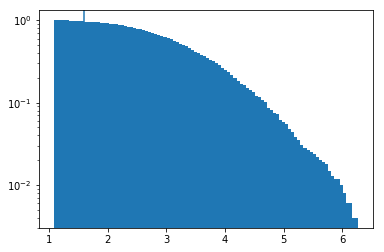

In [20]:
plt.hist(values_r[0], bins=100, cumulative=-1, density=True, log=True)
plt.axvline(val_r[0], 0, 1)

In [21]:
val_s, values_s, _ = null_models.eval_null_data(x, y, shuffle_data, [corrected_lfi_data, lda_data], 1001)

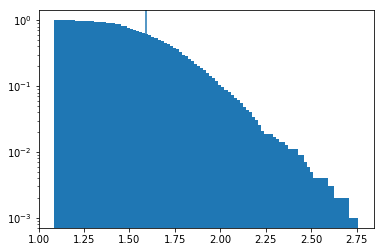

In [22]:
plt.hist(values_s[0], bins=100, cumulative=-1, density=True, log=True)
plt.axvline(val_s[0], 0, 1)

(-7.681145747868608, 7.681145747868608)

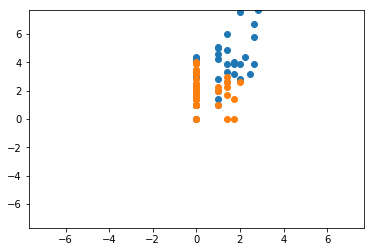

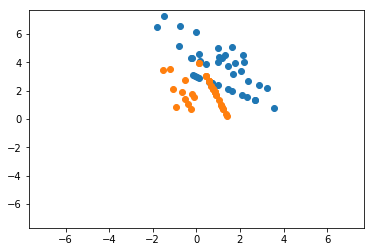

In [24]:
start = 0
x2 = x[:, start:start+2]
y2 = y[:, start:start+2]
m = max(x2.max(), y2.max())
plt.scatter(*x2.T)
plt.scatter(*y2.T)
plt.xlim(-m, m)
plt.ylim(-m, m)
plt.figure()
x2r = null_models.random_rotation_data(x2)
y2r = null_models.random_rotation_data(y2)
plt.scatter(*x2r.T)
plt.scatter(*y2r.T)
plt.xlim(-m, m)
plt.ylim(-m, m)

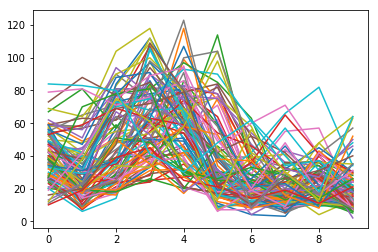

In [36]:
delta = 10
for start in range(100):
    plt.plot(Y[start*delta:(start+1)*delta].sum(axis=1))

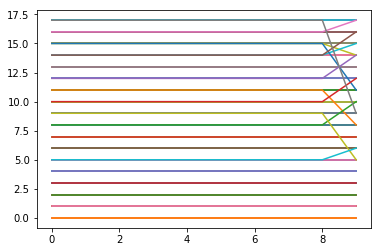

In [38]:
for start in range(100):
    plt.plot(np.argmax(X_1h[start*delta:(start+1)*delta], axis=1))

In [136]:
def plot_pair_corr(Y, angles, ii, jj, plot_angles, faxes=None):
    if faxes is None:
        faxes = plt.subplots()
    f, ax = faxes
    x = []
    xa = []
    y = []
    ya = []
    for kk, angle in enumerate(plot_angles):
        idxs = np.where(angles == angle)[0]
        x.append(Y[idxs][:, ii].mean())
        y.append(Y[idxs][:, jj].mean())
        xa.append(Y[idxs][:, ii])
        ya.append(Y[idxs][:, jj])
    idxs = np.where(angles == plot_angles[0])[0]
    x.append(Y[idxs][:, ii].mean())
    y.append(Y[idxs][:, jj].mean())
    plt.plot(x, y, c='k')
    for x, y in zip(xa, ya):
        plt.scatter(x, y)
        plt.plot(x.mean(), y.mean(), '*', ms=10)
    return faxes

def scatter_ps(Y, angles, ii, jj, plot_angles, n_boot, faxes=None):
    if faxes is None:
        faxes = plt.subplots(1, 2, figsize=(10, 5))
    f, (ax0, ax1) = faxes
    ps = np.zeros((2, 2, plot_angles.size-1))
    for kk, angle in enumerate(plot_angles[:-1]):
        angle = plot_angles[kk]
        idxs = np.where(angle == angles)[0]
        x = np.sqrt(Y[idxs][:, [ii, jj]])
        angle = plot_angles[kk+1]
        idxs = np.where(angle == angles)[0]
        y = np.sqrt(Y[idxs][:, [ii, jj]])
        val_r, values_r, ps_r = null_models.eval_null_data(x, y, random_rotation_data, [corrected_lfi_data, lda_data], n_boot)
        val_s, values_s, ps_s = null_models.eval_null_data(x, y, shuffle_data, [corrected_lfi_data, lda_data], n_boot)
        ps[0, :, kk] = ps_r
        ps[1, :, kk] = ps_s
    ax0.scatter(ps[1, 0], ps[0, 0])
    ax1.scatter(ps[1, 1], ps[0, 1])
    print(np.log10(ps.min(axis=(0, 2))))
    print(np.floor(np.log10(ps.min(axis=(0, 2)))))
    m = np.power(10., np.floor(np.log10(ps.min(axis=(0, 2)))))
    print(m)
    ax0.set_title('cLFI')
    ax1.set_title('LDA Accuracy')
    for kk, ax in enumerate(faxes[1]):
        ax.set_xlim(m[kk], 1)
        ax.set_ylim(m[kk], 1)
        ax.set_xscale('log')
        ax.set_yscale('log')
        ax.plot([m[kk], 1], [m[kk], 1], c='k')
        ax.axhline(.05, m[kk], 1, c='k')
        ax.axvline(.05, m[kk], 1, c='k')
        ax.set_ylabel('Rotation p-value')
        ax.set_xlabel('Shuffle p-value')

def hist_vals(x, y, faxes=None):
    if faxes is None:
        faxes = plt.subplots(2, 2, figsize=(10, 10))
    f, axes = faxes
    val_r, values_r, _ = null_models.eval_null_data(x, y, random_rotation_data, [corrected_lfi_data, lda_data], n_boot)
    ax = axes[0, 0]
    ax.hist(values_r[0], bins=100, cumulative=-1, density=True, log=True)
    ax.axvline(val_r[0], 0, 1, c='k')
    ax.axhline(.05, 0, 1, c='k')
    ax = axes[0, 1]
    ax.hist(values_r[1], bins=100, cumulative=-1, density=True, log=True)
    ax.axvline(val_r[1], 0, 1, c='k')
    ax.axhline(.05, 0, 1, c='k')

    val_s, values_s, _ = null_models.eval_null_data(x, y, shuffle_data, [corrected_lfi_data, lda_data], n_boot)
    ax = axes[1, 0]
    ax.hist(values_s[0], bins=100, cumulative=-1, density=True, log=True)
    ax.axvline(val_s[0], 0, 1, c='k')
    ax.axhline(.05, 0, 1, c='k')
    ax = axes[1, 1]
    ax.hist(values_s[1], bins=100, cumulative=-1, density=True, log=True)
    ax.axvline(val_s[1], 0, 1, c='k')
    ax.axhline(.05, 0, 1, c='k')

In [137]:
n_boot = 1000

[-1.02227639 -0.98716278]
[-2. -1.]
[0.01 0.1 ]


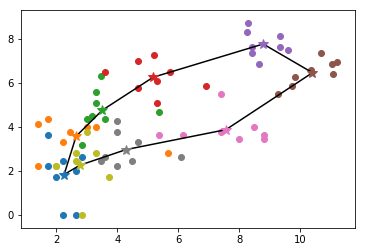

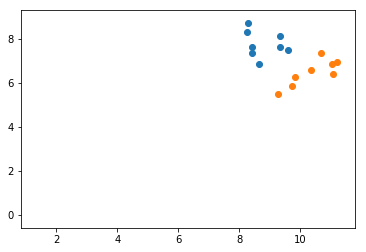

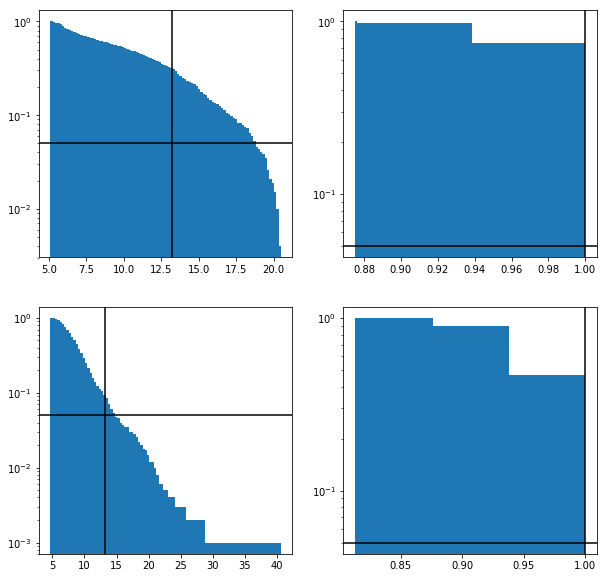

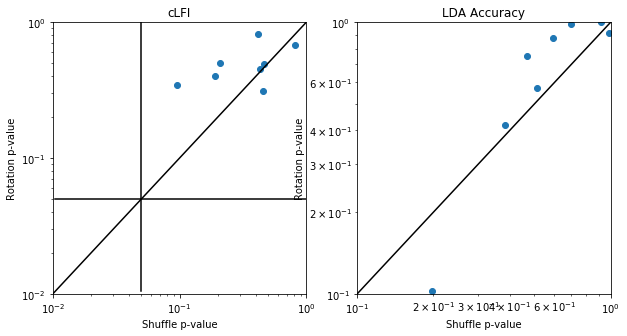

In [138]:
da = 4
ii = 7
jj = 8
cas = center_angles[[ii, jj]]
if abs(np.diff(cas)) > 4:
    plot_angles = np.concatenate([angle_list[int(np.floor(cas.mean() + n_angles/2. - da)) % n_angles:],
                                  angle_list[:int(np.floor(cas.mean() - n_angles/2. + da)) % n_angles]])
else:
    plot_angles = angle_list[int(np.floor(cas.mean()-da)):int(np.ceil(cas.mean()+da))]
_, ax0 = plot_pair_corr(np.sqrt(Y), angles, ii, jj, plot_angles=plot_angles)

angle = plot_angles[4]
idxs = np.where(angle == angles)[0]
x = np.sqrt(Y[idxs][:, [ii, jj]])
angle = plot_angles[5]
idxs = np.where(angle == angles)[0]
y = np.sqrt(Y[idxs][:, [ii, jj]])
f, ax = plt.subplots()
ax.scatter(*x.T)
ax.scatter(*y.T)
ax.set_xlim(ax0.get_xlim())
ax.set_ylim(ax0.get_ylim())

hist_vals(x, y)

scatter_ps(Y, angles, ii, jj, plot_angles, n_boot)

[-1.95860731 -0.30891851]
[-2. -1.]
[0.01 0.1 ]


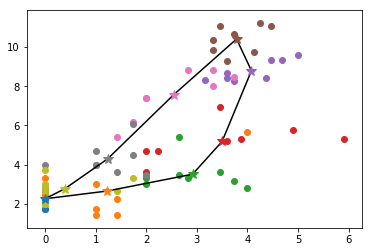

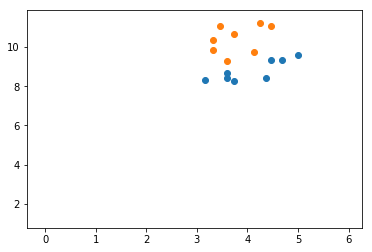

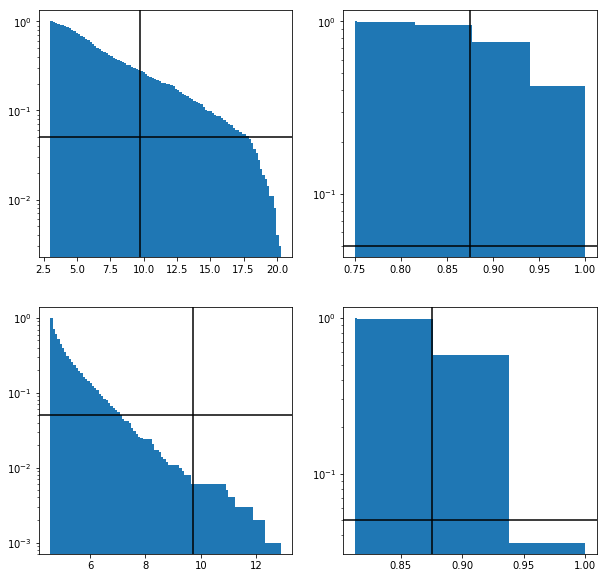

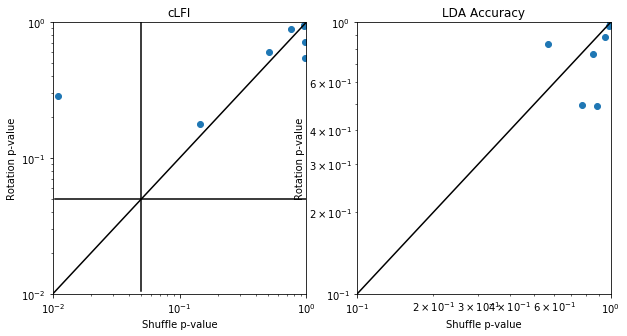

In [120]:
ii = 5
jj = 7
cas = center_angles[[ii, jj]]
if abs(np.diff(cas)) > 4:
    plot_angles = np.concatenate([angle_list[int(np.floor(cas.mean() + n_angles/2. - da)) % n_angles:],
                                  angle_list[:int(np.floor(cas.mean() - n_angles/2. + da)) % n_angles]])
else:
    plot_angles = angle_list[int(np.floor(cas.mean()-da)):int(np.ceil(cas.mean()+da))]
_, ax0 = plot_pair_corr(np.sqrt(Y), angles, ii, jj, plot_angles=plot_angles)

angle = plot_angles[4]
idxs = np.where(angle == angles)[0]
x = np.sqrt(Y[idxs][:, [ii, jj]])
angle = plot_angles[5]
idxs = np.where(angle == angles)[0]
y = np.sqrt(Y[idxs][:, [ii, jj]])
f, ax = plt.subplots()
ax.scatter(*x.T)
ax.scatter(*y.T)
ax.set_xlim(ax0.get_xlim())
ax.set_ylim(ax0.get_ylim())

hist_vals(x, y)

scatter_ps(Y, angles, ii, jj, plot_angles, n_boot)

[-1.50863831 -0.64206515]
[-2. -1.]
[0.01 0.1 ]


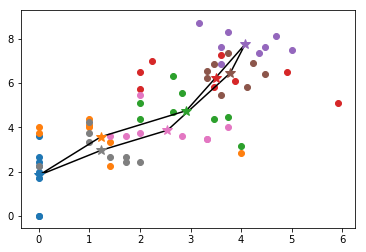

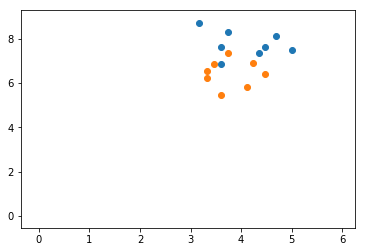

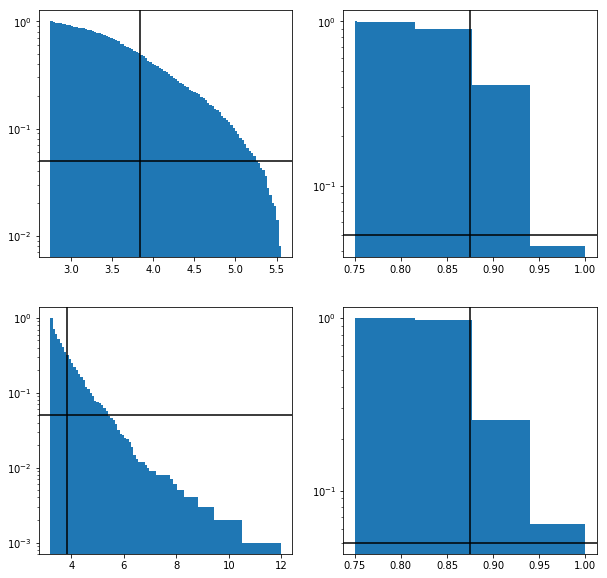

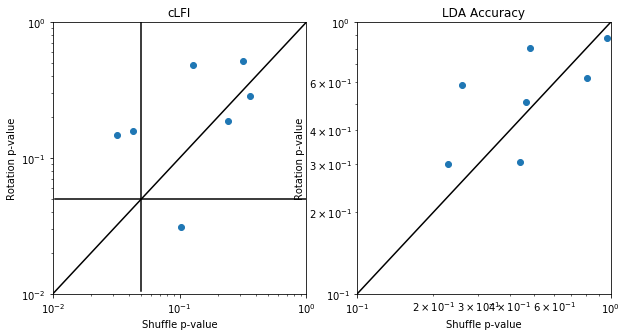

In [121]:
ii = 5
jj = 8
cas = center_angles[[ii, jj]]
if abs(np.diff(cas)) > 4:
    plot_angles = np.concatenate([angle_list[int(np.floor(cas.mean() + n_angles/2. - da)) % n_angles:],
                                  angle_list[:int(np.floor(cas.mean() - n_angles/2. + da)) % n_angles]])
else:
    plot_angles = angle_list[int(np.floor(cas.mean()-da)):int(np.ceil(cas.mean()+da))]
_, ax0 = plot_pair_corr(np.sqrt(Y), angles, ii, jj, plot_angles=plot_angles)

angle = plot_angles[4]
idxs = np.where(angle == angles)[0]
x = np.sqrt(Y[idxs][:, [ii, jj]])
angle = plot_angles[5]
idxs = np.where(angle == angles)[0]
y = np.sqrt(Y[idxs][:, [ii, jj]])
f, ax = plt.subplots()
ax.scatter(*x.T)
ax.scatter(*y.T)
ax.set_xlim(ax0.get_xlim())
ax.set_ylim(ax0.get_ylim())

hist_vals(x, y)

scatter_ps(Y, angles, ii, jj, plot_angles, n_boot)

[-1.67778071 -0.4202164 ]
[-2. -1.]
[0.01 0.1 ]


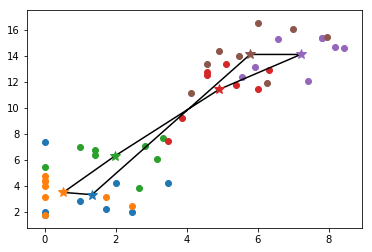

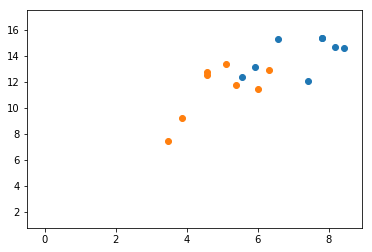

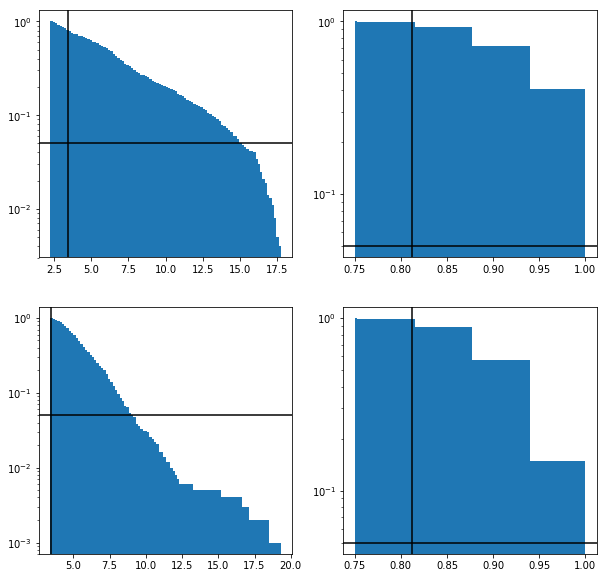

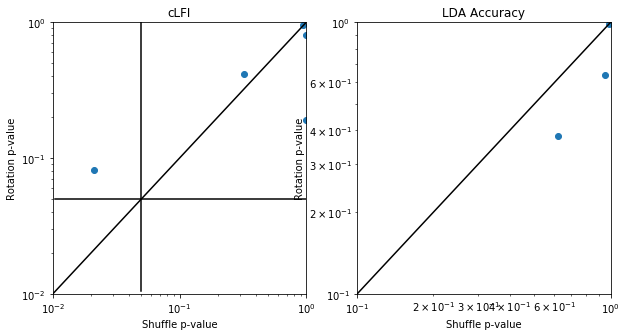

In [125]:
ii = 0
jj = 1
cas = center_angles[[ii, jj]]
if abs(np.diff(cas)) > 4:
    plot_angles = np.concatenate([angle_list[int(np.floor(cas.mean() + n_angles/2. - da)) % n_angles:],
                                  angle_list[:int(np.floor(cas.mean() - n_angles/2. + da)) % n_angles]])
else:
    plot_angles = angle_list[int(np.floor(cas.mean()-da)):int(np.ceil(cas.mean()+da))]
_, ax0 = plot_pair_corr(np.sqrt(Y), angles, ii, jj, plot_angles=plot_angles)

angle = plot_angles[4]
idxs = np.where(angle == angles)[0]
x = np.sqrt(Y[idxs][:, [ii, jj]])
angle = plot_angles[3]
idxs = np.where(angle == angles)[0]
y = np.sqrt(Y[idxs][:, [ii, jj]])
f, ax = plt.subplots()
ax.scatter(*x.T)
ax.scatter(*y.T)
ax.set_xlim(ax0.get_xlim())
ax.set_ylim(ax0.get_ylim())

hist_vals(x, y)

scatter_ps(Y, angles, ii, jj, plot_angles, n_boot)

[-1.52287875 -0.5421181 ]
[-2. -1.]
[0.01 0.1 ]


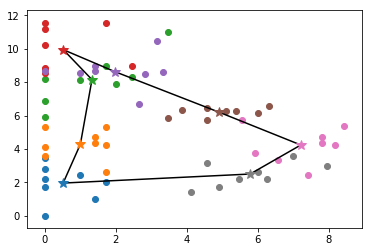

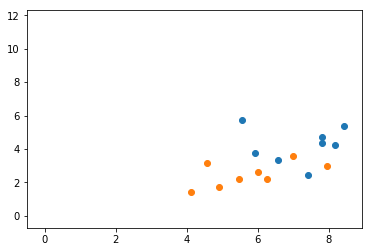

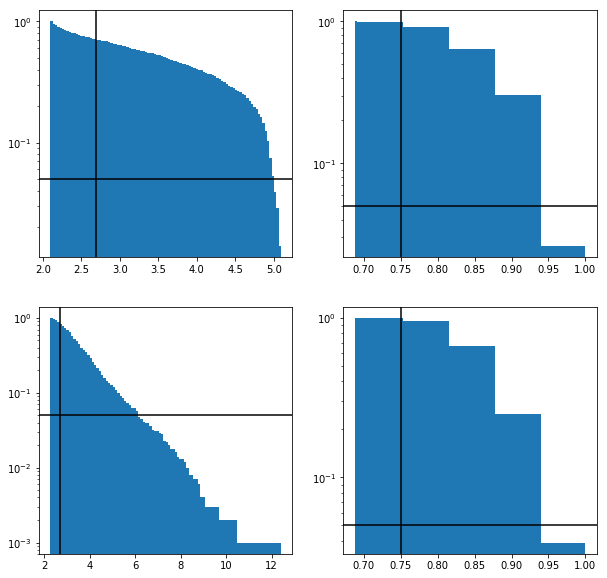

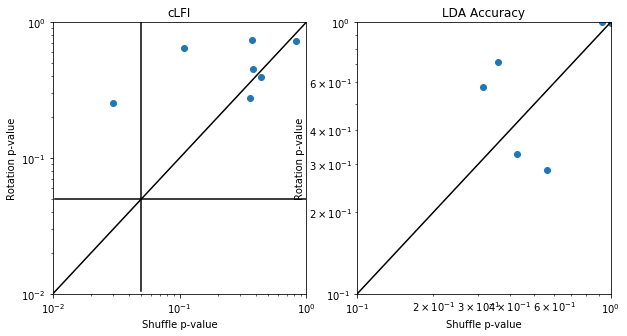

In [126]:
ii = 0
jj = 4
cas = center_angles[[ii, jj]]
if abs(np.diff(cas)) > 4:
    plot_angles = np.concatenate([angle_list[int(np.floor(cas.mean() + n_angles/2. - da)) % n_angles:],
                                  angle_list[:int(np.floor(cas.mean() - n_angles/2. + da)) % n_angles]])
else:
    plot_angles = angle_list[int(np.floor(cas.mean()-da)):int(np.ceil(cas.mean()+da))]
_, ax0 = plot_pair_corr(np.sqrt(Y), angles, ii, jj, plot_angles=plot_angles)

angle = plot_angles[6]
idxs = np.where(angle == angles)[0]
x = np.sqrt(Y[idxs][:, [ii, jj]])
angle = plot_angles[7]
idxs = np.where(angle == angles)[0]
y = np.sqrt(Y[idxs][:, [ii, jj]])
f, ax = plt.subplots()
ax.scatter(*x.T)
ax.scatter(*y.T)
ax.set_xlim(ax0.get_xlim())
ax.set_ylim(ax0.get_ylim())

hist_vals(x, y)

scatter_ps(Y, angles, ii, jj, plot_angles, n_boot)

[-1.52287875 -0.67985371]
[-2. -1.]
[0.01 0.1 ]


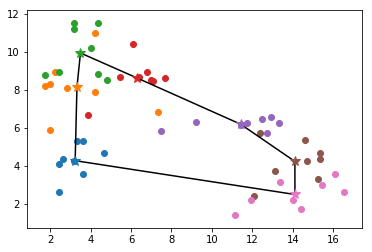

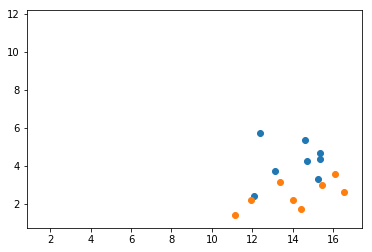

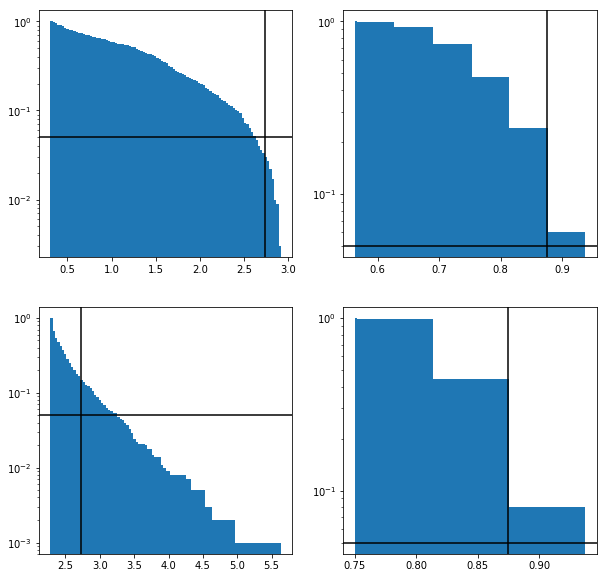

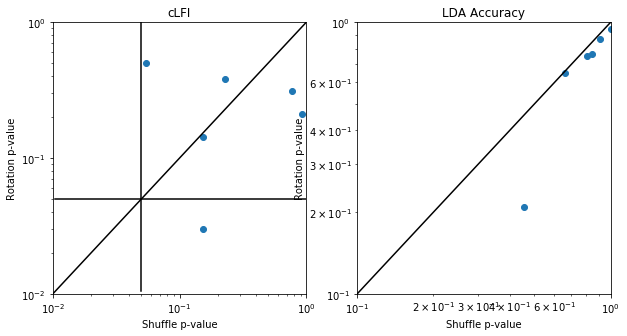

In [142]:
ii = 1
jj = 4
cas = center_angles[[ii, jj]]
if abs(np.diff(cas)) > 4:
    plot_angles = np.concatenate([angle_list[int(np.floor(cas.mean() + n_angles/2. - da)) % n_angles:],
                                  angle_list[:int(np.floor(cas.mean() - n_angles/2. + da)) % n_angles]])
else:
    plot_angles = angle_list[int(np.floor(cas.mean()-da)):int(np.ceil(cas.mean()+da))]
_, ax0 = plot_pair_corr(np.sqrt(Y), angles, ii, jj, plot_angles=plot_angles)

angle = plot_angles[5]
idxs = np.where(angle == angles)[0]
x = np.sqrt(Y[idxs][:, [ii, jj]])
angle = plot_angles[6]
idxs = np.where(angle == angles)[0]
y = np.sqrt(Y[idxs][:, [ii, jj]])
f, ax = plt.subplots()
ax.scatter(*x.T)
ax.scatter(*y.T)
ax.set_xlim(ax0.get_xlim())
ax.set_ylim(ax0.get_ylim())

hist_vals(x, y)

scatter_ps(Y, angles, ii, jj, plot_angles, n_boot)

In [141]:
cas = center_angles[[ii, jj]]
print(cas)
if abs(np.diff(cas)) > 4:
    plot_angles = np.concatenate([angle_list[int(np.floor(cas.mean() + n_angles/2. - da)) % n_angles:],
                                  angle_list[:int(np.floor(cas.mean() - n_angles/2. + da)) % n_angles]])
else:
    plot_angles = angle_list[int(np.floor(cas.mean()-da)):int(np.ceil(cas.mean()+da))]
print(cas)

print(plot_angles)

[17 13]
[17 13]
[220 240 260 280 300 320 340]
